In [1]:
%load_ext autoreload 
%autoreload 2

import logging

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.v2 as transforms
from torchsummary import summary

import matplotlib.pyplot as plt

from medseg.datasets import PH2Dataset
from medseg.models import EncDec
from medseg.training import train, save_metrics
from medseg.metrics import dice_coefficient, iou_loss, accuracy, sensitivity, specificity, bce_loss

logging.basicConfig(level=logging.INFO, format='%(name)s: %(message)s')

In [2]:
#logging.getLogger().setLevel(logging.DEBUG)

In [3]:
torch.cuda.set_device(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
trainset = PH2Dataset('train')
testset = PH2Dataset('test')
valset = PH2Dataset('validation')

batch_size = 6
train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3,
)
val_loader = torch.utils.data.DataLoader(
    valset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=3,
)

## Training

In [5]:
model = EncDec().to(device)
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 254, 254]           1,792
         MaxPool2d-2         [-1, 64, 127, 127]               0
            Conv2d-3         [-1, 64, 125, 125]          36,928
         MaxPool2d-4           [-1, 64, 62, 62]               0
            Conv2d-5           [-1, 64, 60, 60]          36,928
         MaxPool2d-6           [-1, 64, 30, 30]               0
            Conv2d-7           [-1, 64, 28, 28]          36,928
         MaxPool2d-8           [-1, 64, 14, 14]               0
            Conv2d-9           [-1, 64, 12, 12]          36,928
         Upsample-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 14, 14]          36,928
         Upsample-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 30, 30]          36,928
         Upsample-14           [-1, 64,

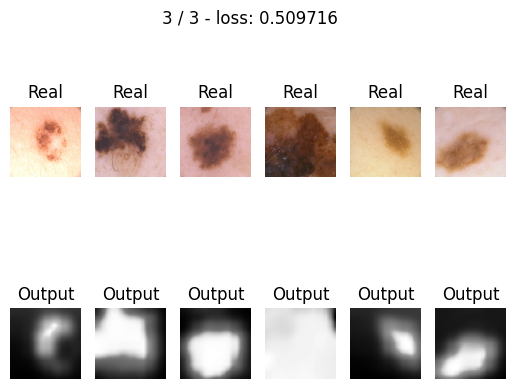

In [6]:
epochs = 3
metrics = train(model, torch.optim.Adam(model.parameters()), bce_loss, epochs, train_loader, val_loader, device)

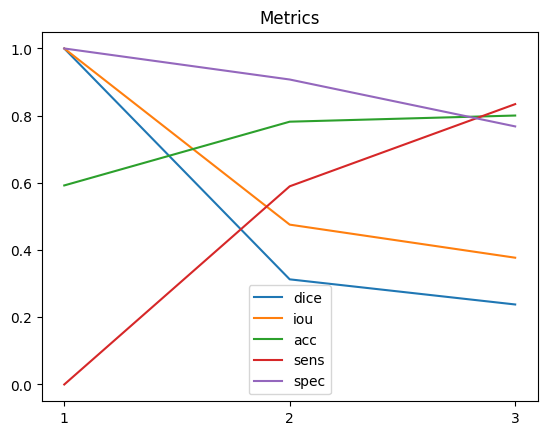

In [7]:
for metric, vec in metrics.items():
    plt.title('Metrics')
    plt.plot(range(1, len(vec)+1), vec, label=metric)
    plt.xticks(range(1, len(vec)+1))
    plt.legend()

In [8]:
save_metrics('example-metrics.csv', metrics, overwrite=True)
%cat example-metrics.csv

epoch,dice,iou,acc,sens,spec
0,0.9999985098838806,1.0,0.5923919677734375,0.0,1.0
1,0.3128986358642578,0.4757114052772522,0.7821226119995117,0.5898210406303406,0.9076318144798279
2,0.2381022721529007,0.3772825598716736,0.8004328012466431,0.8344107866287231,0.7680580615997314
